# Prepare data

In [1]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

from hpsklearn import HyperoptEstimator

In [2]:
pheme = pd.read_csv('datasets\pheme.csv')
politifact = pd.read_csv('datasets\politifact.csv')
twitter = pd.read_csv('datasets\\twitter.csv')

In [4]:
x = pheme['text']
y = pheme['target']

In [18]:
max = 0
for text in pheme['text']:
    if len(text) > max:
        max = len(text)
max

149

In [77]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

token = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)
pad_seq = pad_sequences(seq,maxlen=300)
vocab_size = len(token.word_index)+1

embedding_vector = {}
f = open('glove\glove.twitter.27B.200d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size,200))
hits=0
misses=0
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value
        hits +=1
    else:
        misses += 1
print(f"Converted {hits} words and {misses} misses")

1193514it [01:05, 18212.35it/s]
100%|██████████| 3839/3839 [00:00<00:00, 426597.78it/s]

Converted 3456 words and 383 misses


In [79]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

id2label = {0: "False", 1: "True"}
label2id = {"False": 0, "True": 1}

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

tf_train_set = model.prepare_tf_dataset(
    pheme['text'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

NameError: name 'data_collator' is not defined

In [3]:
from zeugma.embeddings import EmbeddingTransformer

glove = EmbeddingTransformer('glove')
texts = glove.transform(pheme['text'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(texts, pheme['target'], test_size = 0.25, random_state = 42)

In [5]:
X_train.shape

(1801, 25)

In [5]:
def encode_two_datasets(set1, set2):
    tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
    all_statements = np.append(set1, set2)
    all_tf = tfidf.fit_transform(all_statements)
    return all_tf[:len(set1)], all_tf[len(set1):]

In [8]:
rs = 42
method = 3
tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = CountVectorizer(max_df=0.6, min_df=0)

if method == 0:
    pheme_tf = tfidf.fit_transform(pheme['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(pheme_tf, pheme['target'], test_size = 0.25, random_state = rs)
elif method == 1:
    polit_tf = tfidf.fit_transform(politifact['statement'].values)
    X_train, X_test, y_train, y_test = train_test_split(polit_tf, politifact['verdict'], test_size = 0.25, random_state = rs)
elif method == 2:
    twitter_tf = tfidf.fit_transform(twitter['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(twitter_tf, twitter['verdict'], test_size = 0.25, random_state = rs)
elif method == 3:
    X_train, X_test = encode_two_datasets(twitter['text'].values, pheme['text'].values)
    y_test = pheme['target']
    y_train = twitter['verdict']
else:
    X_train, X_test = encode_two_datasets(politifact['statement'].values, pheme['text'].values)
    y_train = politifact['verdict']
    y_test = pheme['target']
    

# Set no. of folds
num_folds = 10

###Things to do: add more features
print(X_train.shape)

(1729, 6101)


# Run models

In [7]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [8]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [6]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=50)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [7]:
# SVM
from hpsklearn import svc 
svm = optimize_model(svc("mySVC", probability=True), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.69s/trial, best loss: 0.2991689750692521]
{'learner': SVC(C=0.8653200557300446, coef0=0.9763153738071819,
    decision_function_shape='ovo', degree=5, gamma='auto', kernel='poly',
    probability=True, random_state=0, shrinking=False,
    tol=0.0023197388995424887), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 70.22 %
F1: 69.9 %


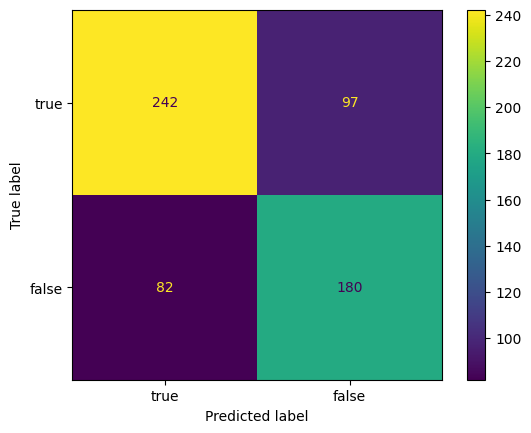

In [8]:
evaluate_model(svm, X_test, y_test)

In [9]:
# KNN
from hpsklearn import k_neighbors_classifier
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN", metric=knn_metrics), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.19s/trial, best loss: 0.23822714681440438]
{'learner': KNeighborsClassifier(algorithm='ball_tree', leaf_size=36, metric='l1', n_jobs=1,
                     n_neighbors=8, p=2.88339724606582, weights='distance'), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 73.04 %
F1: 72.26 %


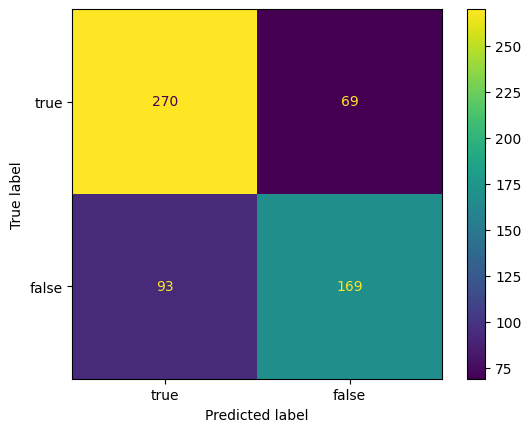

In [10]:
evaluate_model(knn, X_test, y_test)

In [13]:
# Logistic Regression logistic_regression
from hpsklearn import logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.20s/trial, best loss: 0.33518005540166207]
{'learner': LogisticRegression(C=0.23178248517654204, max_iter=670, n_jobs=1,
                   random_state=0, solver='newton-cg',
                   tol=0.008620699565730704), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 64.89 %
F1: 64.01 %


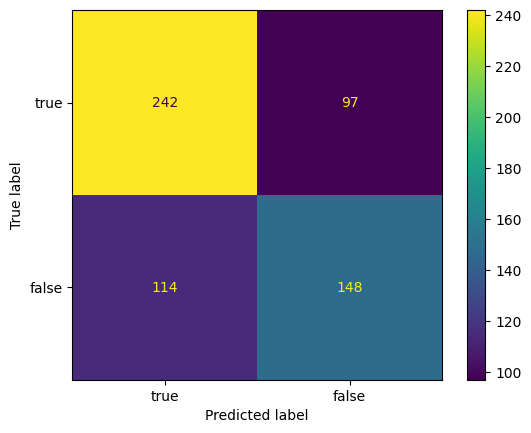

In [14]:
evaluate_model(myLR, X_test, y_test)

In [15]:
# AdaBoost
from hpsklearn import ada_boost_classifier, decision_tree_classifier
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", base_estimator=baseDT), X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:03<00:00,  3.22s/trial, best loss: 0.20775623268698062]
{'learner': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_features='sqrt',
                                                         random_state=3,
                                                         splitter='random'),
                   learning_rate=0.00011314691801508087, n_estimators=742,
                   random_state=4), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 74.04 %
F1: 73.43 %


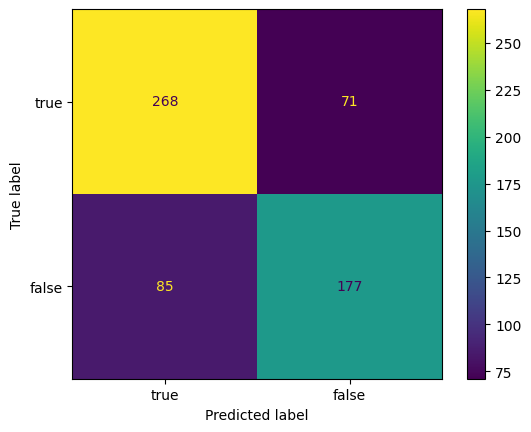

In [16]:
# Run model with best results
evaluate_model(ada, X_test, y_test)

In [17]:
from hpsklearn import mlp_classifier

mlp = optimize_model(mlp_classifier("mlp"), X_train, y_train)

100%|██████████| 50/50 [00:03<00:00,  3.06s/trial, best loss: 0.22160664819944598]
{'learner': MLPClassifier(alpha=0.002156337396112198, beta_1=0.9138490478894561,
              beta_2=0.9660438508547131, epsilon=7.757695240437691e-07,
              learning_rate_init=0.020475034024462588, max_fun=26960,
              max_iter=306, momentum=0.9218635754480133, n_iter_no_change=30,
              power_t=0.6452892589295462, random_state=0,
              tol=0.004536679459942234, validation_fraction=0.1342212184554585), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 69.72 %
F1: 69.51 %


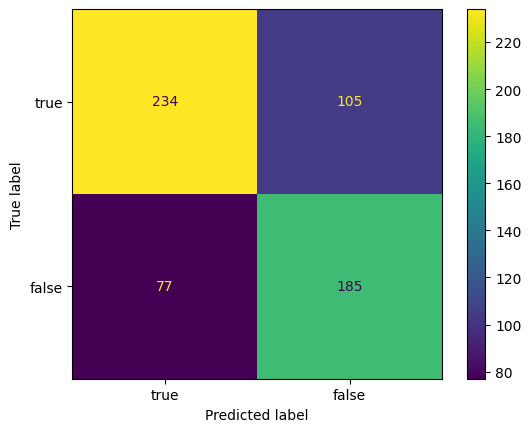

In [18]:
evaluate_model(mlp, X_test, y_test)

# Clustering

In [58]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture().fit(X_train)
gm.means_


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

## Ensemble

In [19]:
sk_svm = svm.best_model()['learner']
sk_knn = knn.best_model()['learner']
sk_LR = myLR.best_model()['learner']
sk_ada = ada.best_model()['learner']
sk_mlp = mlp.best_model()['learner']

Accuracy: 72.05 %
F1: 71.5 %


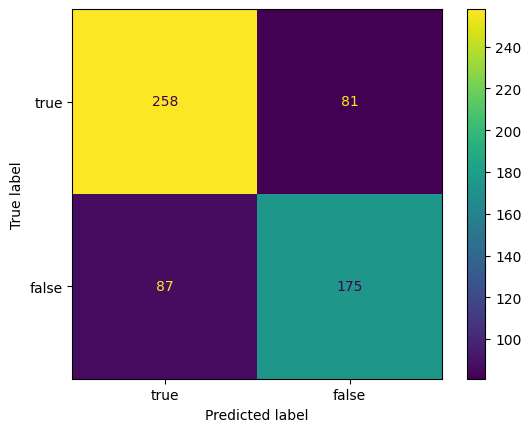

In [20]:
# Hard voting
from sklearn.ensemble import VotingClassifier

sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]
names = ["svm", "LR", "ada", "mlp", "knn"]

hardvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="hard")
hardvoter.fit(X_train, y_train)
evaluate_model(hardvoter, X_test, y_test)

Accuracy: 73.71 %
F1: 73.22 %


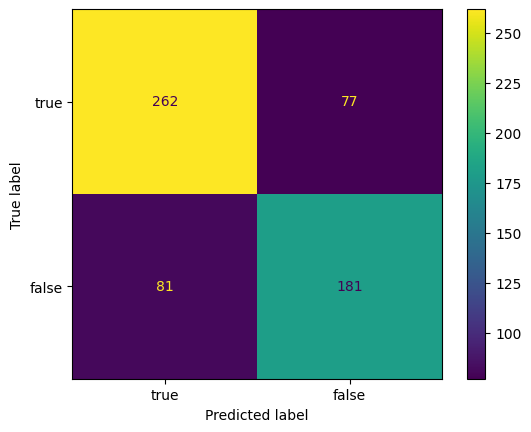

In [21]:
softvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="soft")
softvoter.fit(X_train, y_train)
evaluate_model(softvoter, X_test, y_test)

In [23]:
from deslib.des import KNORAE
sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]
names = ["svm", "LR", "ada", "mlp", "knn"]
ensemble = KNORAE(pool_classifiers=sk_classifiers)

ensemble.fit(X_train, y_train)


KNORAE(pool_classifiers=[SVC(C=0.8653200557300446, coef0=0.9763153738071819,
                             decision_function_shape='ovo', degree=5,
                             gamma='auto', kernel='poly', probability=True,
                             random_state=0, shrinking=False,
                             tol=0.0023197388995424887),
                         LogisticRegression(C=0.23178248517654204, max_iter=670,
                                            n_jobs=1, random_state=0,
                                            solver='newton-cg',
                                            tol=0.008620699565730704),
                         AdaBoostCla...
                                       learning_rate_init=0.020475034024462588,
                                       max_fun=26960, max_iter=306,
                                       momentum=0.9218635754480133,
                                       n_iter_no_change=30,
                                       power_t=0.6452892

Accuracy: 72.88 %
F1: 71.41 %


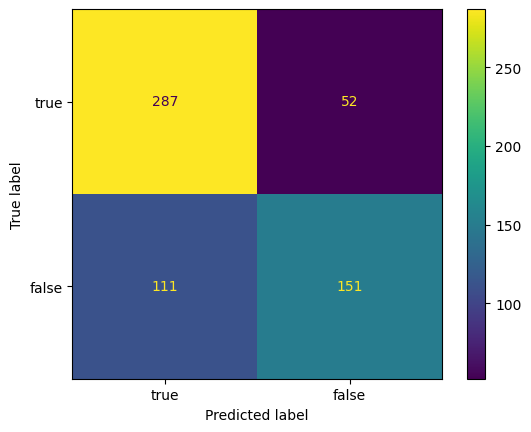

In [26]:
#predy = ensemble.score(X_test, y_test)
#print(predy)
evaluate_model(ensemble, X_test, y_test)

In [27]:
from deslib.des import KNORAU

ensemble = KNORAU(pool_classifiers=sk_classifiers)

ensemble.fit(X_train, y_train)

KNORAU(pool_classifiers=[SVC(C=0.8653200557300446, coef0=0.9763153738071819,
                             decision_function_shape='ovo', degree=5,
                             gamma='auto', kernel='poly', probability=True,
                             random_state=0, shrinking=False,
                             tol=0.0023197388995424887),
                         LogisticRegression(C=0.23178248517654204, max_iter=670,
                                            n_jobs=1, random_state=0,
                                            solver='newton-cg',
                                            tol=0.008620699565730704),
                         AdaBoostCla...
                                       learning_rate_init=0.020475034024462588,
                                       max_fun=26960, max_iter=306,
                                       momentum=0.9218635754480133,
                                       n_iter_no_change=30,
                                       power_t=0.6452892

Accuracy: 72.71 %
F1: 72.13 %


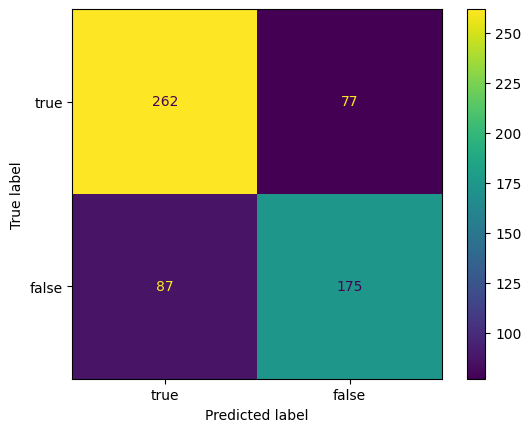

In [28]:
evaluate_model(ensemble, X_test, y_test)